# Description

This notebook examines whether we can predict yields using fertilizer information, rainfall data, and characteristics of farmers. The aim is to predict 2018 treatment productivity based on the amount of fertilizer applied to determing whether we would expect to see a yield increase given the level of rainfall and fertilizer applied if the treatment did not otherwise effect farming practices. 

# reNDVI

First try to predict raw reNDVI values in 2017, which may be more consistent across years since it doesn't depend on farmer recall. We will store results in the same dataframe for all outcome measures, and then save them as a CSV. A lot of code is redundant because it jsut gets copied and pasted from one measure to the next. 

## Data preparation and imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd 
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.ipython.ggplot import image_png

base = importr('base')
stats = importr('stats')
jtools = importr('jtools')

pandas2ri.activate()
pandas2ri.default_timezone = 'GMT'  # To avoid warning 

In [2]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

# Create dataframe to store predictions 
results = pd.DataFrame(index=raw_df.index)
results['uid'] = results.index.str[:-4]
results['year'] = pd.to_numeric(results.index.str[-4:])
results['treatment'] = raw_df['treatment']
results.loc[results['year'] == 2017, 'yield_hectare_2017'] = raw_df['yield_hectare_']
results['yield_hectare_2017'] = results.groupby(['uid'])['yield_hectare_2017'].ffill()
results.loc[results['year'] == 2017, 'sat_yield_2017'] = raw_df['satellite_yield_']
results['sat_yield_2017'] = results.groupby(['uid'])['sat_yield_2017'].ffill()
results.loc[results['year'] == 2017, 'max_re705_2016'] = raw_df['lag_re705_']
results['max_re705_2016'] = results.groupby(['uid'])['max_re705_2016'].ffill()
results.loc[results['year'] == 2018, 'max_re705_2017'] = raw_df['lag_re705_']
results['max_re705_2017'] = results.groupby(['uid'])['max_re705_2017'].bfill()

raw_df.drop(columns = ['yield_hectare_', 'satellite_yield_'], inplace=True)  # Just look at Red-edge NDVI values for now

raw_df.dropna(subset=['max_re705_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)

# Separate IVs and DVs
y = df[['max_re705_']]
X = df.drop(columns=['max_re705_'])
full_y = full_df[['max_re705_']]
full_X = full_df.drop(columns=['max_re705_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [3]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'max_re705_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['max_re705_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("max_re705")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [4]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 0.00031814
Optimal l1_ratio: 1.000
Number of iterations 10
Training R^2: 0.27625275210910116
Out of sample R^2: 0.25904678891224


### Feature importance

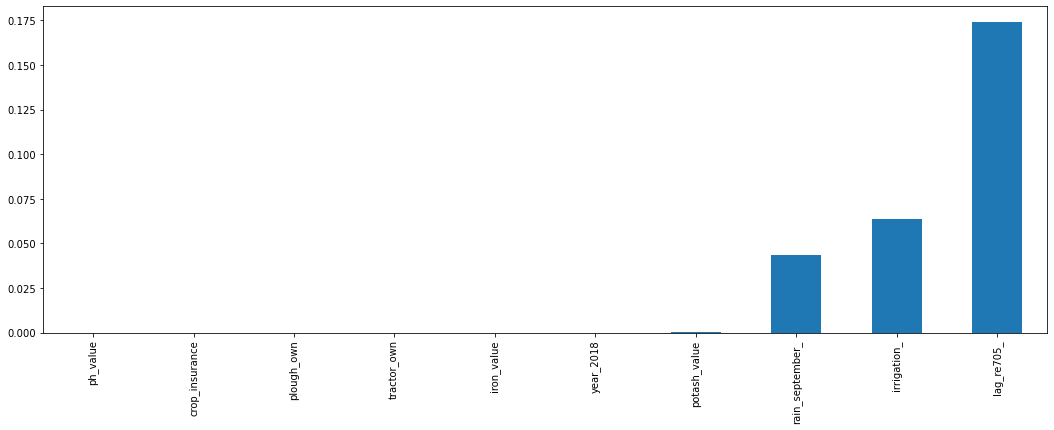

In [5]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

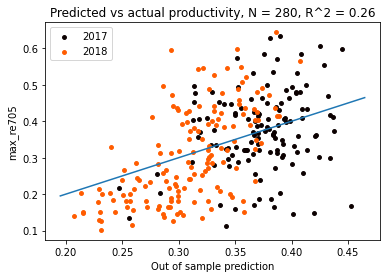

In [6]:
scatter_out_of_sample(e_net)

### Save predictions 

In [7]:
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  
id                                                                            
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383  
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818  
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262  
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112  
B01V01F00042017       2053.3210        0.3

## Random forest

In [8]:
#GridSearchCV
n_estimators = [500, 1000, 1500]  # Trees
max_features = ['sqrt']  # Max feature to consider at each split 
max_depth = [10, 15, 20]  
min_samples_split = [2, 3, 4]
min_samples_leaf = [2, 3, 4]
bootstrap = [True]

# Create the grid 
grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
        'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_cv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, cv=5, n_jobs = 6, scoring='r2')
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)
rf = rf_cv.best_estimator_
print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Training R^2: 0.8585398928589777
Out of sample R^2: 0.4392867573784499


### Feature importances 

In [9]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
lag_re705_              0.096444
rain_september_         0.088943
urea_                   0.079292
rain_july_              0.069757
rain_june_              0.064831
rain_october_           0.063207
potash_value            0.060049
irrigation_             0.053874
rain_august_            0.048631
ec_value                0.040900
nitrogen_value          0.039747
phosphorous_value       0.035981
ph_value                0.035388
sulphur_value           0.035040
sow_time                0.034601
dap_                    0.034483
soil_test_zinc_value    0.033035
iron_value              0.032468
knowledge_              0.017352
year_2018               0.008909


### Scatter plot: predicted vs true value out of sample 

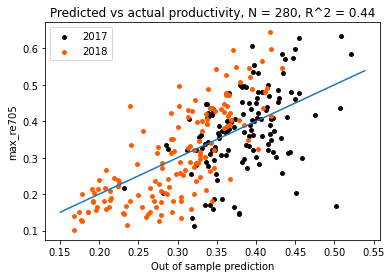

In [10]:
scatter_out_of_sample(rf)

### Save predictions 

In [11]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

## Neural net

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.7204044122468615
Out of sample R^2: 0.16745646961142924


### Scatter plot: predicted vs true value out of sample

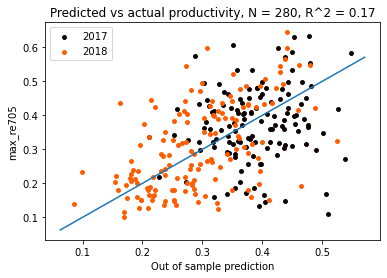

In [13]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'max_re705_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['max_re705_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("max_re705")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [14]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

# Satellite measured yields

Second, examine satellite yield measurements. These are just affine transformations of the reNDVI values examined above. However, the transformations are separately estimated from farmer-reported yields in 2017 and 2018, so they may be less consistent across years. 

## Data preparation and imports

In [15]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

raw_df.drop(columns = ['max_re705_', 'yield_hectare_'], inplace=True) 

raw_df.dropna(subset=['satellite_yield_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)

# Separate IVs and DVs
y = df[['satellite_yield_']]
X = df.drop(columns=['satellite_yield_'])
full_y = full_df[['satellite_yield_']]
full_X = full_df.drop(columns=['satellite_yield_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [16]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'satellite_yield_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['satellite_yield_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("satellite_yield_")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [17]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 1.14446638
Optimal l1_ratio: 1.000
Number of iterations 29
Training R^2: 0.6308120441632172
Out of sample R^2: 0.6123473197403733


### Feature importance

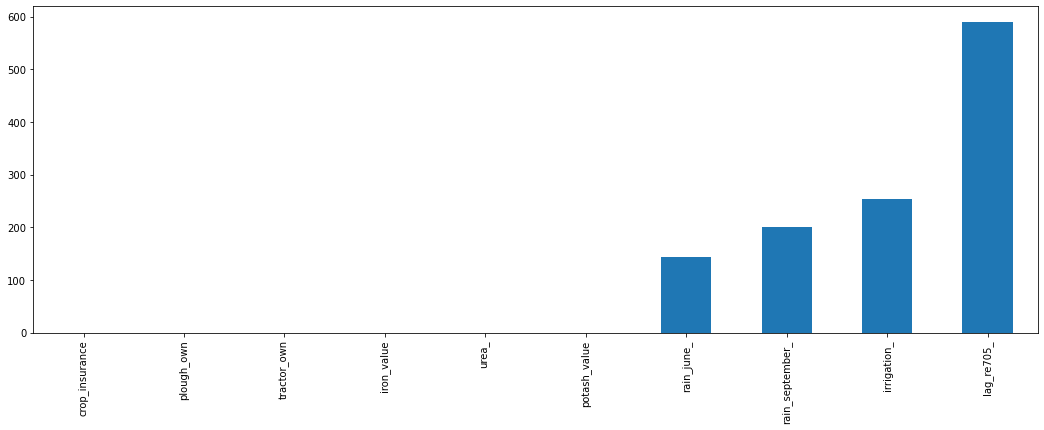

In [18]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

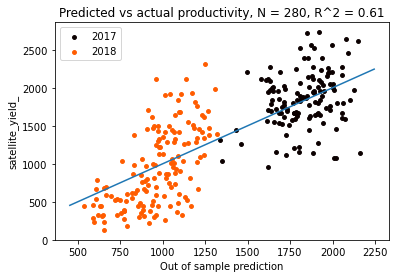

In [19]:
scatter_out_of_sample(e_net)

### Save predictions 

In [20]:
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

## Random forest

In [21]:
#GridSearchCV
n_estimators = [1000, 1500, 2000]  # Trees
max_features = ['sqrt']  # Max feature to consider at each split 
max_depth = [10, 15, 20]  
min_samples_split = [3, 4]
min_samples_leaf = [3, 4]
bootstrap = [True]

# Create the grid 
grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
        'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_cv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, cv=5, n_jobs = 6, scoring='r2')
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)
rf = rf_cv.best_estimator_
print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 2000}
Training R^2: 0.8960929877033237
Out of sample R^2: 0.7033767462561515


### Feature importances 

In [22]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
rain_july_              0.139489
rain_june_              0.122457
rain_august_            0.115833
rain_september_         0.110371
year_2018               0.103862
rain_october_           0.086222
lag_re705_              0.047195
urea_                   0.044715
irrigation_             0.037532
potash_value            0.028675
dap_                    0.018254
ec_value                0.017807
nitrogen_value          0.017290
sulphur_value           0.015905
phosphorous_value       0.015770
sow_time                0.015255
ph_value                0.015089
soil_test_zinc_value    0.014444
iron_value              0.013979
knowledge_              0.008001


### Scatter plot: predicted vs true value out of sample 

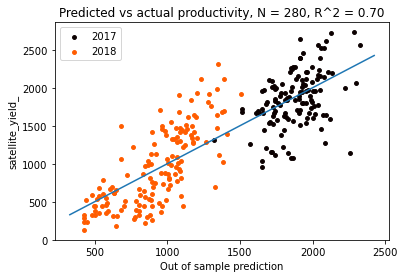

In [23]:
scatter_out_of_sample(rf)

### Save predictions 

In [24]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

## Neural net

In [25]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.683176763424062
Out of sample R^2: 0.5895540066117599


### Scatter plot: predicted vs true value out of sample

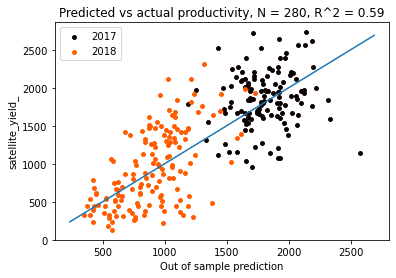

In [26]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'satellite_yield_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['satellite_yield_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("satellite_yield_")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [27]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

# Farmer-reported yields

Thurd, examine satellite yield measurements. 

## Data preparation and imports

In [28]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

raw_df.drop(columns = ['max_re705_', 'satellite_yield_'], inplace=True)  # Just look at Red-edge NDVI values for now

raw_df.dropna(subset=['yield_hectare_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)

# Separate IVs and DVs
y = df[['yield_hectare_']]
X = df.drop(columns=['yield_hectare_'])
full_y = full_df[['yield_hectare_']]
full_X = full_df.drop(columns=['yield_hectare_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [29]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'yield_hectare_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['yield_hectare_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("yield_hectare_")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [30]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 0.16208458
Optimal l1_ratio: 1.000
Number of iterations 171
Training R^2: 0.32779573029669484
Out of sample R^2: 0.36796963781531966


### Feature importance

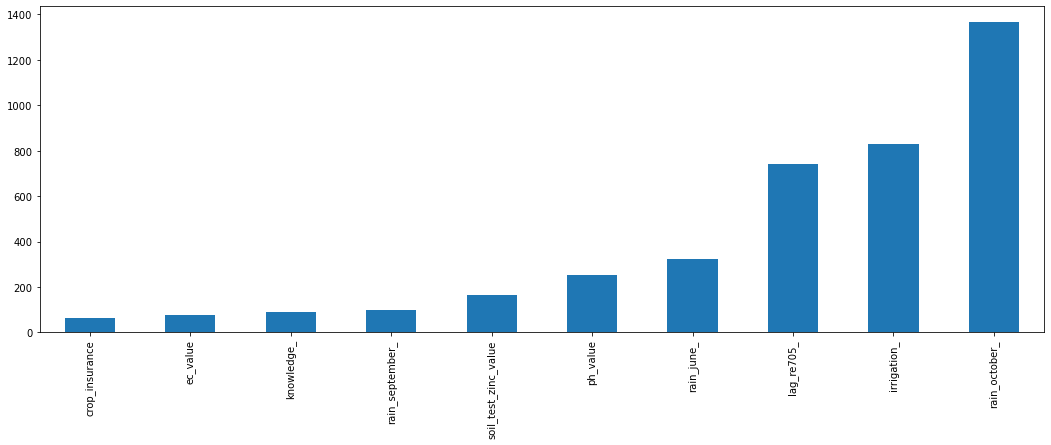

In [31]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

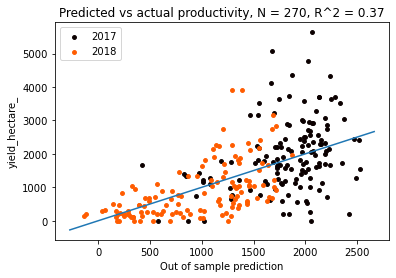

In [32]:
scatter_out_of_sample(e_net)

### Save predictions 

In [33]:
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

## Random forest

In [34]:
#GridSearchCV
n_estimators = [500, 1000, 1500]  # Trees
max_features = ['sqrt']  # Max feature to consider at each split 
max_depth = [5, 10, 15]  
min_samples_split = [3, 4, 5]
min_samples_leaf = [3, 4]
bootstrap = [True]

# Create the grid 
grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
        'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_cv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, cv=5, n_jobs = 6, scoring='r2')
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)
rf = rf_cv.best_estimator_
print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 500}
Training R^2: 0.7182278252476186
Out of sample R^2: 0.40493953915556713


### Feature importances 

In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
irrigation_             0.105384
urea_                   0.096314
rain_september_         0.077691
rain_june_              0.062634
rain_july_              0.060754
sow_time                0.057110
lag_re705_              0.055402
potash_value            0.055001
rain_august_            0.052203
rain_october_           0.044161
dap_                    0.041151
ec_value                0.037398
ph_value                0.035767
sulphur_value           0.031416
soil_test_zinc_value    0.031011
phosphorous_value       0.030760
nitrogen_value          0.029890
iron_value              0.026574
year_2018               0.024260
knowledge_              0.017597


### Scatter plot: predicted vs true value out of sample 

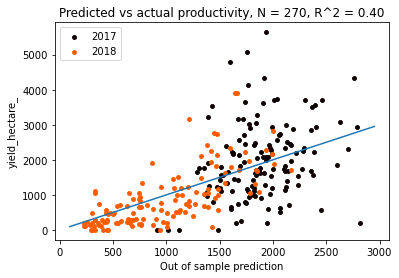

In [36]:
scatter_out_of_sample(rf)

### Save predictions 

In [37]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

## Neural net

In [38]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.4011558134294497
Out of sample R^2: 0.3300245833750609


### Scatter plot: predicted vs true value out of sample

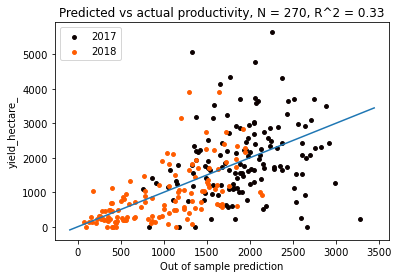

In [39]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'yield_hectare_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['yield_hectare_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("yield_hectare_")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [40]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())
results.to_csv('../data/nosync/predicted_yields.csv')

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.336818   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.359112   
B01V01F00042017       2053.3210     

# Analysis 

We next examine whether there is an expected treatment effect given the predicted yields.

## Reshape results to wide

In [41]:
values = [x for x in results.columns if x not in ['uid', 'year']]
results['year'] = pd.to_numeric(results['year'])
results_wide = results.pivot(index='uid', columns='year', values=values)
results_wide.columns = results_wide.columns.to_flat_index()

years = [2017, 2018]
to_rename = {}
to_drop = []
for x in values:
    #  First process variables that are not constant across years
    if x in ['e_net_re705', 'e_net_satellite_yield', 'e_net_fr_yield',
            'rf_re705', 'rf_satellite_yield', 'rf_fr_yield',
            'nn_re705', 'nn_satellite_yield', 'nn_fr_yield']:
        for y in years:
            to_rename[(x,y)] = x + '_' + str(y)
    #  Second process variables that are constant across years
    else:
        to_rename[(x,years[0])] = x
        to_drop.append((x,years[1]))

results_wide.drop(columns=to_drop, inplace=True)
results_wide.rename(columns=to_rename, inplace=True)

## reNDVI

R[write to console]: Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools

R[write to console]: Loading required namespace: broom.mixed



MODEL INFO:
Observations: 1385 (3 missing obs. deleted)
Dependent Variable: rf_re705_2018
Type: OLS linear regression 

MODEL FIT:
F(3,1381) = 109.98, p = 0.00
R² = 0.19
Adj. R² = 0.19 

Standard errors: Robust, type = HC1
--------------------------------------------------
                       Est.   S.E.   t val.      p
-------------------- ------ ------ -------- ------
(Intercept)            0.18   0.01    26.28   0.00
treatment              0.00   0.00     0.03   0.98
max_re705_2017         0.17   0.02    10.06   0.00
max_re705_2016         0.17   0.02     9.34   0.00
--------------------------------------------------



R[write to console]: Registered S3 methods overwritten by 'broom.mixed':
  method         from 
  augment.lme    broom
  augment.merMod broom
  glance.lme     broom
  glance.merMod  broom
  glance.stanreg broom
  tidy.brmsfit   broom
  tidy.gamlss    broom
  tidy.lme       broom
  tidy.merMod    broom
  tidy.rjags     broom
  tidy.stanfit   broom
  tidy.stanreg   broom



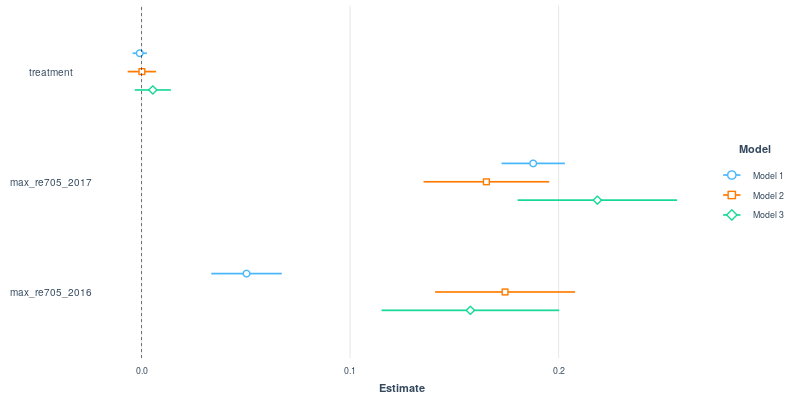

In [42]:
robjects.globalenv['results'] = results_wide
re705_e_net = stats.lm('e_net_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
re705_rf = stats.lm('rf_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
re705_nn = stats.lm('nn_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
print(jtools.summ(re705_rf, robust = "HC1"))  # Print the regression results from the best model

p = jtools.plot_summs(re705_e_net, re705_rf, re705_nn, ci_level = 0.95)  # Plot regression coefficients for each model
image_png(p)

In [43]:
%load_ext rpy2.ipython

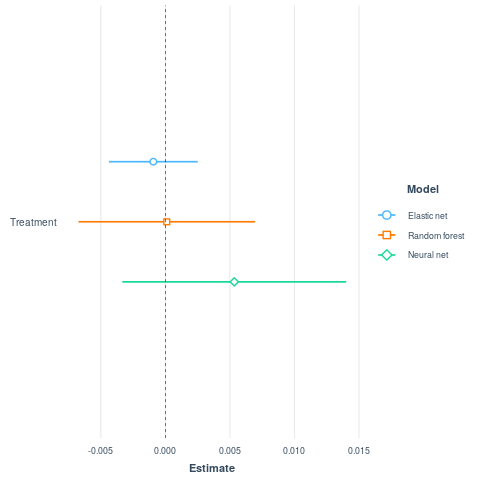

In [44]:
%%R
re705_e_net = lm('e_net_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
re705_rf = lm('rf_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
re705_nn = lm('nn_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(re705_e_net, re705_rf, re705_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))

## Satellite yield

In [45]:
sat_e_net = stats.lm('e_net_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
sat_rf = stats.lm('rf_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
sat_nn = stats.lm('nn_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
print(jtools.summ(sat_rf, robust = "HC1"))  # Print the regression results from the best model

MODEL INFO:
Observations: 1385 (3 missing obs. deleted)
Dependent Variable: rf_satellite_yield_2018
Type: OLS linear regression 

MODEL FIT:
F(3,1381) = 101.25, p = 0.00
R² = 0.18
Adj. R² = 0.18 

Standard errors: Robust, type = HC1
-----------------------------------------------------
                         Est.    S.E.   t val.      p
-------------------- -------- ------- -------- ------
(Intercept)            376.55   33.38    11.28   0.00
treatment                1.51   13.63     0.11   0.91
sat_yield_2017           0.18    0.02     9.82   0.00
max_re705_2016         645.27   72.83     8.86   0.00
-----------------------------------------------------



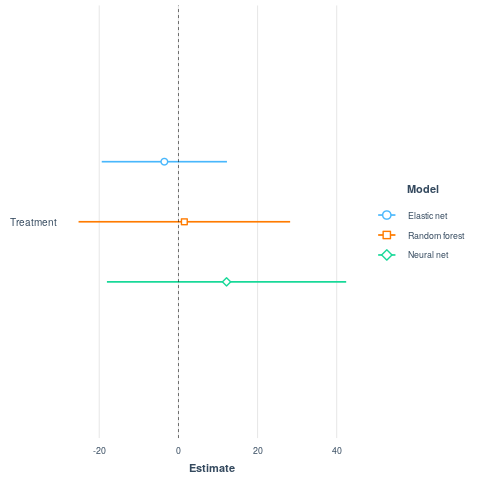

In [46]:
%%R
sat_e_net = lm('e_net_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', results)
sat_rf = lm('rf_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=results)
sat_nn = lm('nn_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(sat_e_net, sat_rf, sat_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))

## Farmer-reported yield

In [47]:
fr_e_net = stats.lm('e_net_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
fr_rf = stats.lm('rf_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
fr_nn = stats.lm('nn_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
print(jtools.summ(fr_rf, robust = "HC1"))  # Print the regression results from the best model

MODEL INFO:
Observations: 1286 (102 missing obs. deleted)
Dependent Variable: rf_fr_yield_2018
Type: OLS linear regression 

MODEL FIT:
F(2,1283) = 30.93, p = 0.00
R² = 0.05
Adj. R² = 0.04 

Standard errors: Robust, type = HC1
---------------------------------------------------------
                             Est.    S.E.   t val.      p
------------------------ -------- ------- -------- ------
(Intercept)                787.66   32.22    24.45   0.00
treatment                   19.65   30.15     0.65   0.51
yield_hectare_2017           0.10    0.01     7.84   0.00
---------------------------------------------------------



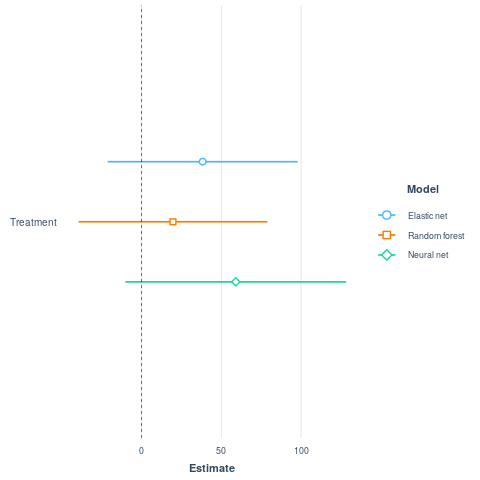

In [48]:
%%R
fr_e_net = lm('e_net_fr_yield_2018 ~ treatment + yield_hectare_2017', results)
fr_rf = lm('rf_fr_yield_2018 ~ treatment + yield_hectare_2017', data=results)
fr_nn = lm('nn_fr_yield_2018 ~ treatment + yield_hectare_2017', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(fr_e_net, fr_rf, fr_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))